# 2.3 Titanic: Machine Learning from Disaster

## step 4

In [3]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [6]:
from IPython.display import HTML
style = "<style>svg{width:30% !imp
ortant;height:30% !important;}</style>"
HTML(style)

Считаем данные из датасета.

In [5]:
titanic_data = pd.read_csv("train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Описание датафрейма:

+ PassengerId - id пассажира
+ Survived - выжил пассажир или нет
+ Pclass - класс биллета, который он приобрёл
+ Name - имя
+ Sex - пол
+ Age - возраст
+ SibSp - число сопутствующих с ним пассажиров
+ Parch - число родителей/детей на борту Титаника
+ Ticket - номер билета
+ Fare - 
+ Cabin - каюта, в которой он ехал
+ Embarked - Порт погрузки(C = Шербур, Q = Куинстаун, S = Саутгемптон)

**Задача: обучить дерево решений, которое будет предсказывать выжил пассажир или не выжил, основываясь на данных пассажиров из датасета train.csv.**

При работе с данными первым делом есть смысл сделать базовую предобработку. Чтобы понять с какими данными в принципе мы работаем.

Как минимум применить метод head() чтобы понять какого типа данные есть в датасете, визуально их рассмотреть. А ещё полезно посмотреть сколько пропущенных значений в колонках. Потому что если есть какие-то переменные, в которых 99% пропущенных значений, то скорее всего от них можно отказаться.

Как проверить в pandas наличие пропущенных значений в нашем датафрейме?

Во-первых, в pandas у датафрейма есть метод isnul(), возвращающий False или True для каждого наблюдения, в зависимости от того является ли наблюдение пропущенным.

In [6]:
titanic_data.isnull().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


Визуально, скорее всего не очень удобно воспринимать результат такой таблицы. Однако, если посчитать сумму, то результат уже можно использовать в работе.

Он будет содержать информацию о том сколько в каждой колонке находится пропущенных значений.

In [7]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Как видно из результатов выше - много данных потеряно о возрасте пассажиров и номерах кают, в которых они совершали путешествия.

Скорее всего в этом нет ничего страшного и для нас особого интереса переменная с номером каюты не представляет. Разве что она может содержть информацию о том где конкретно на Титанике находилась та или иная каюта. Пока для простоты исключим из рассмотрения данную переменную.

Это подталкивает нас к вопросу какие переменные мы будем использовать для обучения.

Повторюсь, сейчас мы не хотим останавливаться на задаче предобработки данных. Во-первых, мы обсудим это при работе с другими данными. Во-вторых, всё это можно посмотреть на [kaggle](kaggle.com), как делают это более скилованные ребята.

Поэтому давайте сейчас отберём только самые очевидные переменные, которые мы будем использовать для обучения и на них обучимся.

Итак, мы выкидаем из наблюдения следующие колонки:
+ Идентификатор пассажира
+ Номер билета
+ Номер каюты
+ Имя пассажира
+ Survived

Поскольку имя пассажира - это очень уникальная особенность конкретно взятого пассажираи использовать имя для вычисления некоторых закономерностей выглядит неразумно.

Survived удаляем не потому, что с ней что-то не так, а потому, что именно её мы и хотим предсказывать.

Как это можно сделать?

1. Сделать список тех фичей, которые нам нужно оставить, и тем самым создать новый датафрейм только с нужными колонками.
2. Из исходного датасета удалить ненужные колонки.

Давайте сделаем это вторым способом. Для этого используем метод `drop()`, передав в него список удаляемых колоной. Чтобы метод понял, что данный список содержит именно названия колонок, а не индексов нашего датафрейма, нужно задать ещё и аргумент axis=1.

In [8]:
X = titanic_data.drop(['PassengerId','Survived','Name', 'Ticket', 'Cabin'], axis=1)

Проверим, что всё удалилось.

In [9]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


Создадим переменную y, в которую положим ту переменную, которую мы будем предсказывать.

In [10]:
y = titanic_data.Survived
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## step 5

Что делать дальше мы уже знаем. Нам нужно дерево решений.

Создаём этот классификатор.

In [11]:
clf = tree.DecisionTreeClassifier()

И обучаем его на наших данных

In [12]:
clf.fit(X,y)

ValueError: could not convert string to float: 'male'

Мы поймали ошибку, связанную с преобразованием данных.

Оказывается в sklearn реализации дерева решений этот алгоритм может работать только с числовыми данными и даже номинативные переменные мы должны закодировать в виде числовых переменных при помощи 0, 1 или других чисел. А вот со строковыми идентификаторами работать, к сожалению, не получится.

Значит продолжаем процесс предобработки данных и избавляемся от переменных, записанных в строковом виде. Это интересная тема и существует несколько способов как это можно сделать.

Например, переменная Survived тоже является номинативной переменной, которая могла быть записана строками, а она записана 0 и 1. 

Вот такой способ кодировки номинативных переменных в количественные называется label incalling - когда мы присваиваем некоторму уровню просто некоторую градацию. Например male будет 0, а female будет 1. 

Это абсолютно допустимый вариант, особенно, когда мы работаем с деревьями решений. Потому что мы теперь будем говорить if Sex > 0.5 значит мы работаем в ситуации когда у нас один пол, а в другой ситуации - другой пол.

Либо есть другой способ one hot encoding когда мы переменную Sex разбиваем на две переменные - у нас будет переменная Sex male и Sex female. Они будут принимать значения либо 0, либо 1 в завиомости от того, что мы получаем.

Я подробнее расскажу о том какой способ предпочтительнее и есть ли предпочтительный способ для работы с деревом решений(забегая вперёд - нет, можно использовать оба).

Поэтому давайте сейчас воспользуемся вторым способом.

Можно добиться этого разными способами:
+ есть специальные методы в sklearn
+ в pandas есть метод get_dummies(), получающий на вход датафрейм и понимающий сам какие переменные нужно преобразовать в dummy variables, потому что если переменная записана в числовом виде, то он и не будет её трогать, а если переменная была записана в строковом виде - то переменная разобьётся на несколько

In [13]:
X = pd.get_dummies(X)

In [14]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Переменная Sex разбилась на Sex_male и Sex_female. А Embarked разбилась сразу на 3 переменные:
+ Embarked_C
+ Embarked_Q
+ Embarked_S

## step 6

Мы со всем разобрались и теперь в нашем датафрейме остались только числовые переменные. Причём есть переменные про пол, которые можно сказать себя дублируют.

В случае линейных моделей это могло бы привести к проблемам, но в случае с деревом решений - это не так страшно. Поэтому оставим всё как есть.

У нас есть X, готовый для передачи его в наше дерево решений. Давайте повторим попытку.

In [15]:
clf.fit(X,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Опять ошибка, но теперь другого рода - оказывается дерево решений не умеет работать с пропущенными значениями. 

Это можно было бы заподозрить ранее. поскольку непонятно как бы интерпретировать результаты вопросов, относящихся к переменной age, имеющей результаты NaN.

Что, кстати, зачастую является сильным недостатком этого метода.

Давайте решим и этот вопрос - заполним пропущенные значения, заодно посмотрим как лучше всего это сделать в pandas.

Вообще заполнение пропущенных значений - это отдельная большая тема. Забегая вперёд можно было бы сообразить, что мы же можем заполнить Age каким-то рандомным числом, а могли бы как-то обучить модель чтобы значения проставлялись "по уму". Но сейчас мы преследуем другие цели, поэтому давайте сделаем более простой вариант - заполним пропущенные значения медианным значением возраста.

Так вычисляется медиана

In [16]:
X.Age.median()

28.0

Запишем её теперь вместо пропусков

In [17]:
X = X.fillna({'Age': X.Age.median()})

Проверим, что всё теперь стало хорошо.

In [18]:
X.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

На этот раз всё готово для обучения нашего дерева. Давайте только для обучения будем использовать энтропию, раз уж мы с ней разобрались на прошлом занятии.

In [19]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [20]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Всё получилось!

Нетерпится посмотреть как же дерево решений смогло нам сказать - какие пассажиры у нас предсказываются как погибшие, какие - как выжившие. Какую закономерность этих данных мы смогли извлечь.

## step 7

Мы сделали всё "по инструкции" и теперь давайте посмотрим как же дерево решений воспользовалось нашими фичами, которые мы нагенерили, и построило понятное(как мы надеемся) дерево решений.

Посмотрим - чему наше дерево решений научилось.

In [21]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/kes/Anaconda3/Library/bin/graphviz' # (укажите свой путь до bin для graphviz)

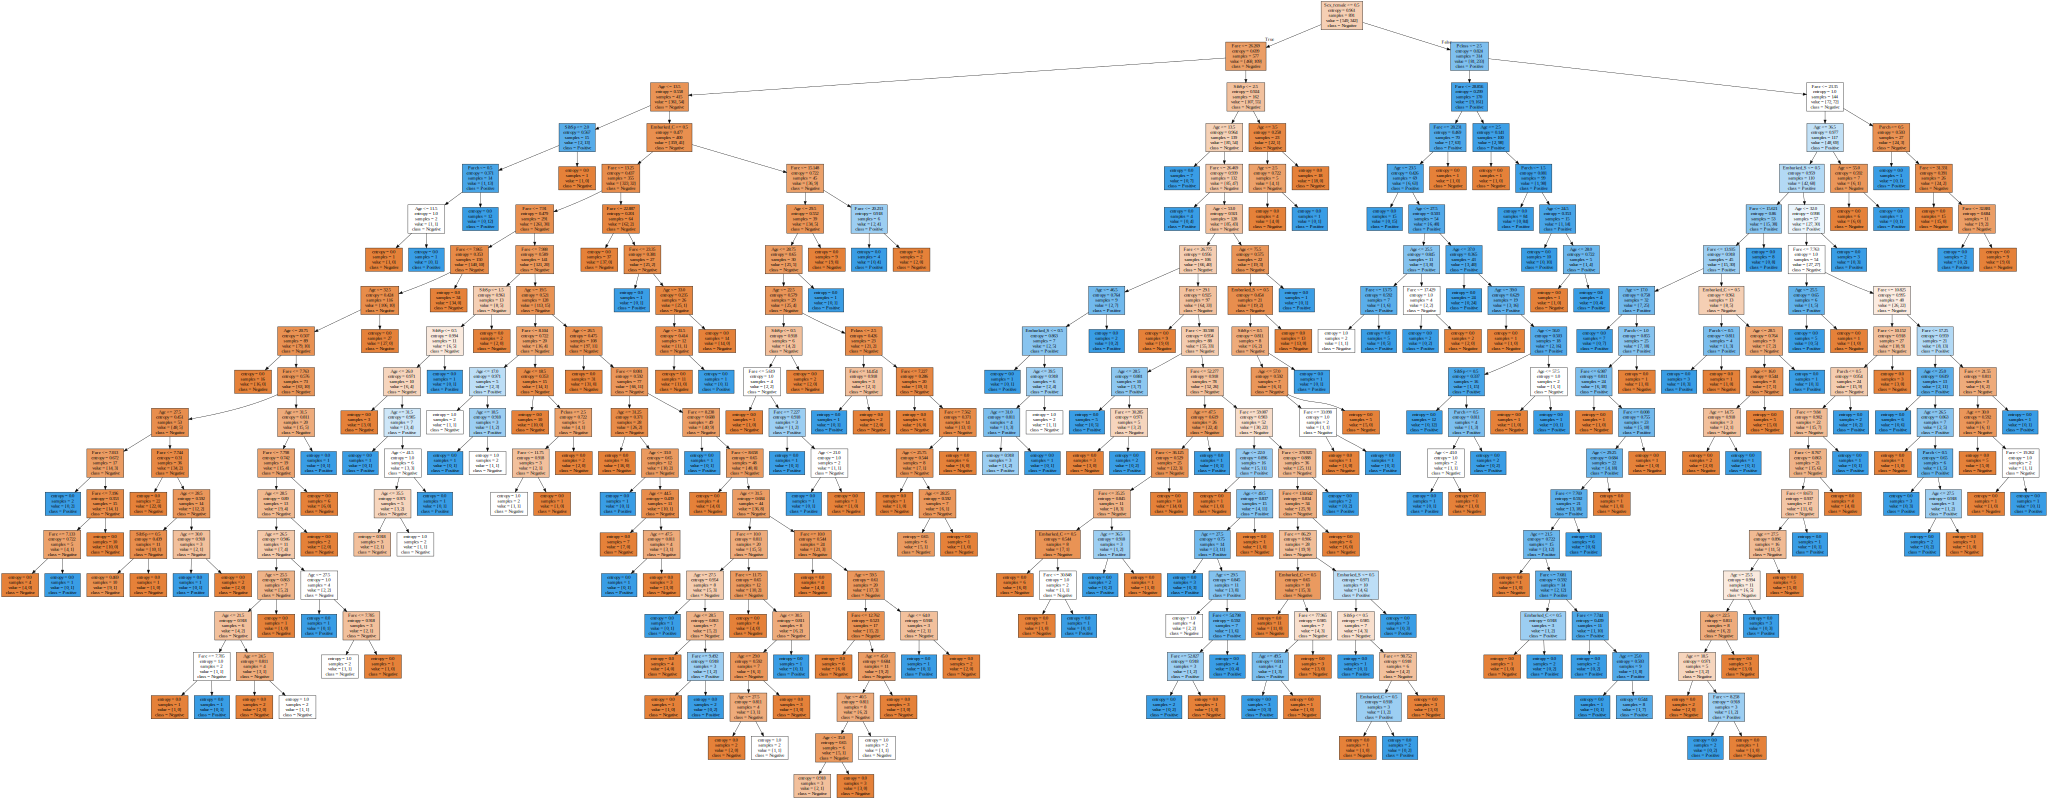

In [22]:
import sklearn
graph = Source(sklearn.tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Negative','Positive'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

Что это такое?

Это вообще непохоже на сколько-нибудь вменяемую конструкцию классификации пассажиров Титаника на то выжили они или нет.

Может с X что-то случилось?

In [23]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Нет. Всё ок - тот же набор фичей.

Но почему наше дерево решений представляет собой огромный набор логических проверок, которые нужно сделать, чтобы классифицировать наши наблюдения.

Выглядит очень странно.

Как минимум не такое дерево решений мы ожидали увидеть.

Посмотрим на наше получившееся дерево - в самом начале у нас 891 пассажир, 549 - погиб, 342 - выжило. 

Первый вопрос про пол, а далее какое-то бесконечное количество комбинаций всех переменных, которые просто не помещаются в один экран и кажется, что что-то пошло не так. 

## step 8

Так что же именно пошло не так? Почему наше дерево решений так разрослось до огромных размеров? 

И кажется, что те взаимосвязи которые оно выстроило - усложнены, и человек решил бы всё явно проще. 

Что случилось?

Случилась интересная штука. Мы примерно разобрали как устроен математический аппарат дерева решений и какой алгоритм там используется. Дерево решений не ставит своей целью вычленить какой-то паттерн, какую-то общую закономерность, которую можно использовать как некоторое генерализированное правило.

Помните с самого начала курс мы говорили о том, что такое обучиться чему-то? Например, научить ребенка отличать кошек от собак. Мы показываем ему 15 кошек и 15 собак и задача ребенка не отличать конкретно этих 15 кошек и 15 собак, а вычислить закономерность из этих 30 примеров и затем отличать между собой любых кошек и собак.

А в дереве решений, которое мы описали, это никак не заложено. Всё что делает дерево решений это говорит - пока я могу ещё снизить энтропию я буду снижать энтропию и разделять кошек от собак, кошек от собак до тех пор, пока все кошки не будут классифицированы как кошки, а собака - как собаки. И это далеко не то же самое, что вычленить общую закономерность.

Подытожим всё вышесказанное. То что мы наблюдали называется **переобучение** или **overfitting нашей модели**.

Мы сказали нашей модели не **вычлени закономерность в нашей модели, которая разделяет наших пассажиров на: выжил/не выжил**, а мы сказали дереву **вот тебе наш датафрейм, вот переменная y - сделай такое дерево решений, которое безошибочно классифицирует все наблюдения в нашем датафрейме**.

Как только мы спускаемся всё ниже и ниже у нас возникают новые неопределённости.

То есть дерево решает задачу классификации конкретно этих данных, не вычленяя при этом какое-то правило.Почему так происходит разберёмся ниже.

## step 9

Итак, разберёмся с тем - почему наше дерево получилось таким глубоким.

В нашем классификаторе есть параметр max_depth, который в нашем примере задан как None, т.е. наше дерево может расти сколько угодно.

Почему же это привело к таким результатам?

Пусть у нас есть набор данных: крестики и кружочки

![датасет](images/dataset.png)

Мы хотим наше дерево решений научить классифицировать крестики и кружочки. 

У нас есть две переменные: X1 и X2 и тип - крестики или кружочки. 

Дерево решений смотрит наши данные, пробегается по двум нашим фичам и находит первый оптимальный сплит.

Допустим первый сплит будет таким

![первый сплит](images/first_split.png)

Что происходит в этом случае?

Изначально у нас было 7 крестиков и 9 кружочков:

![исходное состояние](images/first.png)

Мы делаем первый сплит - говорим "правда ли, что x1 > n", где n - некоторый показатель.

Если это так, тогда у нас остаются только одни кружочки в количестве 7 штук. Это хорошо, т.к. энтропия в этом случае будет равна 0. Но если x1 < n - то у нас будет 7 крестиков и 2 кружка.

![сплит](images/split.png)

Для того, чтобы их рассплитить дерево решений делает ещё один сплит, например, такой:

![второй сплит](images/second_split.png)

И это будет, скажем, m.

Тогда, если X2 будет больше, чем m - у нас всё будет хорошо. Потому что если это так у нас остаются только кружочки, а если нет - только крестики.

![сплит 2](images/split2.png)

И вот такое дерево показывает некоторую закономерность, которую можно было бы использовать, визуализировать, проговорить, чтобы разделить крестики и кружочки.

Самое интересное начинается когда один кружочек проникнет в центр крестиков.

![](images/at_damn.png)

Дереву решеий теперь не будет покоя до самого конца происходящего. Оно говорит: "стоп, у нас есть кружочек и мы не остановимся в своем углублении до тех пор, пока этот кружочек не победим."

Как будем побеждать?

Давайте сделаем сплит, отбросив 3 крестика

![](images/split3.png)

Справа у нас будут только крестики, а вот слева по-прежнему останется кружок. Нужен ещё сплит.

![](images/split4.png)

Это тоже не до конца решает проблему - справа у нас 2 крестика, а слева по-прежнему остаётся 1 кружок среди 2 крестиков. Нужен ещё сплит.

![](images/final.png)

То есть для того чтобы победить 1 точку, нарушающую общую закономерность, мы взяли и нарастили дерево. Мы потратили столько же глубины дерева сколько потратили на почти все наши данные безошибочно классифицированные всего лишь с одним пропущенным неправильным угадыванием в нашем дереве.

![](images/add.png)

Для того чтобы увидеть эту одну ошибочную точку мы сделали ещё 3 сплита. 

А что было бы если бы среди кружочков при этом ещё был бы крестик? Дерево разросталось бы и там. В этом и есть алгоритм дерева - мы как бы говорим ему: "Дерево, пока у тебя есть возможность снизить энтропию - найди оптимальный сплит, просплиться по нему и посмотри, что дальше".

И вот здесь возникает интересная штука.

Когда мы говорим об общей закономерности, нам зачастую не так важно добиться 100% точности классификации, потому что в большинстве случаев, когда мы говорим про реальные задачи классификации у нас бывают такие ситуации:

![](images/real.png)

Есть два класса, между ними можно провести разделительную поверхность, но у нас довольно часто, просто в силу того, что никогда не бывает идеальной 100% точности, никогда нельзя ожидать, что два класса будут разделены 100%-но. 

То есть для реального мира вот такое разделение было бы хорошим, максимально правильным решением.

![](images/answer.png)

А вот заниматься выискиванием стопроцентного описания каждой такой отдельной ситуации - неправильно. Поскольку наша кривая, описывала бы отлично только одну выборку данных, а для другой выборки уже пришлось бы описывать новую кривую. А примерное решение, допускающее небольшую ошибку (чёрная прямая на предыдущем и следующем рисунках) достаточно хорошо разделила бы классы и на новых данных.

![](images/100.png)

Это и называется переобучением. Когда вместо того чтобы вычленить какую-то более общую закономерность мы занимаемся тем, что пытаемся безошибочно классифицировать каждое наблюдение в нашей выборке. Что далеко не всегда является необходимостью.

## step 10

Почему наше дерево так сильно разрастается, мы разобрались. Потому что дерево "из коробки" не ставит задачу вычленить общую закономерность, правило, закон природы, которое мы дали ему в наших данных. Оно пытается безошибочно классифицировать каждое наблюдение.

Первый вопрос - что с этим делать?

Нам нужно проверить, что наша закономерность, проверенная на нашей выборке, хорошо работает и на новых данных. 

То есть мы прогоняем дерево решений на новых данных и сравниваем предсказанные значения с их реальными значениями. Это позволит нам проверить правильно или нет работает наша модель.

Второй вопрос - как добиться того, чтобы дерево решений решало другую задачу? Именно задачу вычленения общей закономерности.

Здесь нам на помощь приходит концепция подбора параметров. 

У нашего дерева решений есть параметр, который мы можем безболезненно варьировать - глубина дерева. То есть мы можем ограничить количество вопросов, которое дерево может задать нашим данным. 

Что это означает на практике?

Мы говорим дереву: "Смотри у тебя есть Титаник. Ты умеешь правильно подбирать вопросы для снижения энтропии, но у тебя есть только 5 вопросов. Твоя задача задать всего 5, но самых главных вопросов, которые опишут почему одни люди на Титанике умирают, а другие нет".

Именно такой подход ограничения глубины роста дерева вниз отчасти решает нашу проблему переобучения. Потому что когда мы переформулировали задачу дереву: "У тебя есть некоторе ресурсы - воспользуйся ими максимально эффективно".

Посмотрим, как это работает на практике.

##  step 11

Итак, у нас есть 2 идеи:

+ Науиться ограничивать дерево в его стремлении расти как можно глубже
+ Нашему дереву показывать два абора данных:
    + данные, на которых наше дерево обучится
    + данные, на которых дерево протестируется
    
Для этого нам потребуется специальный метод `train_test_split` - удобная функция, получающая на вход датафрейм X с фичами, датафрейм y и разбивает их в заданной пропорции на тестовую и обучающую выборки.

tes_size = 0.33 значит:
+ 33% данных уйдут в тестовую выборку
+ остальное - в обучающую

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.33, random_state=42)

X_train - всё тот же наш датафрейм

In [26]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
6,1,54.0,0,0,51.8625,0,1,0,0,1
718,3,28.0,0,0,15.5000,0,1,0,1,0
685,2,25.0,1,2,41.5792,0,1,1,0,0
73,3,26.0,1,0,14.4542,0,1,1,0,0
882,3,22.0,0,0,10.5167,1,0,0,0,1


только наблюдений у него будет уже 596. 

In [27]:
X_train.shape

(596, 10)

In [28]:
X_test.shape

(295, 10)

Аналогично и с y.

Вернёмся к нашей задаче - убедимся, что у нас есть проблемы с тем деревом, которое мы получили. Потому что на самом деле тот факт, что наше дерево глубокое и большое вообще в каком-то смысле может и не сигнализировать о проблеме.

Может быть закономерность настолько сложная, что описать её деревом меньших масштабов никак не получится. Давайте это проверим.

Проверить это можно сравнив насколько хорошо наше дерево предсказывает правильные ответы на обучающей выборке(train множестве) и насколько хорошо - на тестовой. Это очень упрощённая версия валидации модели.

У классификатора есть метод score, предсказывающий число правильных ответов.

In [32]:
clf.score(X, y)

0.9797979797979798

В 97% случаев мы правильно классифицировали все наши наблюдения на обучающей выборке.

А что если мы возьмём наш классификатор и обучим его на обучающей выборке.

In [33]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Посмотрим какая у нас точность предсказания на обучающей выборке

In [34]:
clf.score(X_train, y_train)

0.9798657718120806

А теперь посмотрим на тестовой выборке, на тех данных, которые наш классификатор не видел.

In [35]:
clf.score(X_test, y_test)

0.7762711864406779

Здесь нужно обратить внимание на большую разницу в полученных значениях на обучащей и тестовой выборках.

Большая разница в значениях говорит об overfitting

ограничим глубину дерева:

In [36]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [37]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
clf.score(X_train, y_train)

0.8238255033557047

In [39]:
clf.score(X_test, y_test)

0.8203389830508474

### эффективный подбор параметров

In [74]:
max_depth_values = range(1, 100)

In [75]:
scores_data = pd.DataFrame()

In [76]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [77]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.806780


https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.melt.html

In [78]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name='set_type', value_name='score')

In [79]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


https://stackoverflow.com/questions/51422146/install-the-latest-version-of-seaborn-0-9-0-through-pip

 pip3 install seaborn==0.9.0

In [49]:
import seaborn

In [52]:
seaborn.__version__

'0.9.0'

https://seaborn.pydata.org/generated/seaborn.lineplot.html

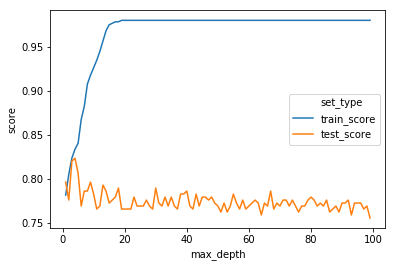

In [54]:
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long)

#### анализ графика:
- с увеличеним глубины дерева растет точность классификации на тренировочной выборке
- но это не всегда ведет к нахождению общих закономерностей исследуемых данных
- test score изначально невелик(модель ещ ене доучилась), на промежутке 3-5 score максимален(оптимальное состояние: закономерность с изученных данных переносится на новые), но в дальнейшем с увеличеним train score начинает падать test score(переход от недообученности к переобученности)

https://scikit-learn.org/stable/modules/cross_validation.html

обучение на нескольких подвыборках выборках:

In [129]:
from sklearn.model_selection import cross_val_score

In [130]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [131]:
cross_val_score(clf, X_train, y_train , cv=5)

array([0.76666667, 0.80833333, 0.78991597, 0.74789916, 0.80508475])

In [132]:
cross_val_score(clf, X_train, y_train , cv=5).mean()

0.7835799743626264

In [136]:
scores_data = pd.DataFrame()

In [137]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train , cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

In [138]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781857
0,2,0.805369,0.776271,0.768553
0,3,0.823826,0.820339,0.788678
0,4,0.833893,0.823729,0.783580
0,5,0.840604,0.810169,0.796942


In [139]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='set_type', value_name='score')

In [140]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


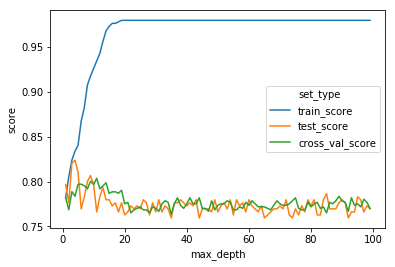

In [141]:
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long)

максимальная точность достигается при большей глубине дерева, чем 3-5

cross_val_score более устойчив к переобучению

найдем дерево с максимальным значением cross_val_score

In [144]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781857
199,2,cross_val_score,0.768553
200,3,cross_val_score,0.788678
201,4,cross_val_score,0.783580
202,5,cross_val_score,0.796942
203,6,cross_val_score,0.797083
204,7,cross_val_score,0.795317
205,8,cross_val_score,0.791885
206,9,cross_val_score,0.800274
207,10,cross_val_score,0.796885


5	cross_val_score	0.800303

In [146]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11)

In [148]:
cross_val_score(best_clf, X_test, y_test , cv=5).mean()

0.7864406779661017